In [1]:
import json
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data as torchData
from torch.utils.data import DataLoader

from collections import OrderedDict

data_path = '/home/strider/Code/robotron/training/data/'

In [28]:
# Load all the classes.
classes = {}
idx = 0
for line in open(data_path + 'classes.txt'):
    classes.setdefault(line.strip(), { 'index': idx, 'heights': [], 'widths': []})
    idx += 1
print(classes)

{'Player': {'index': 0, 'heights': [], 'widths': []}, 'Civilian': {'index': 1, 'heights': [], 'widths': []}, 'Grunt': {'index': 2, 'heights': [], 'widths': []}, 'Hulk': {'index': 3, 'heights': [], 'widths': []}, 'Sphereoid': {'index': 4, 'heights': [], 'widths': []}, 'Enforcer': {'index': 5, 'heights': [], 'widths': []}, 'Brain': {'index': 6, 'heights': [], 'widths': []}, 'Tank': {'index': 7, 'heights': [], 'widths': []}, 'Quark': {'index': 8, 'heights': [], 'widths': []}, 'Electrode': {'index': 9, 'heights': [], 'widths': []}, 'Enforcer Bullet': {'index': 10, 'heights': [], 'widths': []}, 'Converted Civilian': {'index': 11, 'heights': [], 'widths': []}, 'Brain Bullet': {'index': 12, 'heights': [], 'widths': []}}


In [29]:
# We need to prepare each image the same way for the nn
def prepare_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (32, 32))
    return image

In [74]:
# Load all the images from labelbox
data = []
filename = 'export-2020-01-22T06_55_44.481Z.json'
with open(data_path + filename) as json_file:
    data = json.load(json_file)
    
# Our dataset isn't very big, so lets load it all at the begining.
images = {}
for c in classes:
    images[c] = []

for el in data:
    img_name = el["External ID"]
    image_path = f'{data_path}screens/{img_name}'
    
    if not os.path.exists(image_path):
        print(f"Image {img_name} not found")
        continue
    
    image = cv2.imread(image_path) 
    if 'objects' in el['Label'].keys():
        for label in el['Label']['objects']:
            c = label['title']
            ax = label['bbox']['left']
            ay = label['bbox']['top']
            aw = label['bbox']['width']
            ah = label['bbox']['height']
            img = image[ay:ay+ah, ax:ax+aw]
            classes[c]['widths'].append(aw)
            classes[c]['heights'].append(ah)
            
            images[c].append(prepare_image(img))

In [75]:
for i in classes.keys():
    l = len(images[i])
    print(f"{i:>20}: {l:4}")



              Player:  127
            Civilian:  343
               Grunt:  623
                Hulk:  505
           Sphereoid:  121
            Enforcer:  129
               Brain:   77
                Tank:    0
               Quark:    0
           Electrode:  903
     Enforcer Bullet:   71
  Converted Civilian:   15
        Brain Bullet:    7


In [76]:
# Add other images
for c in os.listdir(data_path+'sprites'):
    if c in classes:
        cls_path = f"{data_path}sprites/{c}/"
        for f in os.listdir(cls_path):
            image = cv2.imread(cls_path+f)
            height, width, channels = image.shape 
            classes[c]['widths'].append(width)
            classes[c]['heights'].append(height)
            images[c].append(prepare_image(image))
    else:
        print("Not in class: " + c)

In [81]:
for i in classes.keys():
    l = len(images[i])
    if l > 0:
        print(f"{i:>20}: {l:4}   Dims: Min: {np.min(classes[i]['widths']):2}x{np.min(classes[i]['heights']):2}   Max: {np.max(classes[i]['widths'])}x{np.max(classes[i]['heights'])}    Avg: {math.floor(np.average(classes[i]['widths']))}x{math.floor(np.average(classes[i]['heights']))}")
    else:
        print(f"{i:>20}:    0")

              Player:  162   Dims: Min:  9x24   Max: 25x37    Avg: 17x29
            Civilian: 1021   Dims: Min:  8x21   Max: 28x39    Avg: 18x31
               Grunt: 1052   Dims: Min: 15x21   Max: 34x40    Avg: 24x31
                Hulk: 1248   Dims: Min: 16x24   Max: 40x47    Avg: 29x35
           Sphereoid:  138   Dims: Min:  3x 2   Max: 39x37    Avg: 20x19
            Enforcer:  254   Dims: Min:  8x10   Max: 28x32    Avg: 23x26
               Brain:   80   Dims: Min: 21x29   Max: 37x49    Avg: 30x37
                Tank:    2   Dims: Min: 17x19   Max: 17x19    Avg: 17x19
               Quark:    0
           Electrode:  986   Dims: Min: 13x16   Max: 30x30    Avg: 22x23
     Enforcer Bullet:  153   Dims: Min: 13x 4   Max: 22x20    Avg: 16x16
  Converted Civilian:   15   Dims: Min: 10x26   Max: 25x67    Avg: 18x34
        Brain Bullet:    7   Dims: Min:  6x 7   Max: 47x26    Avg: 28x21


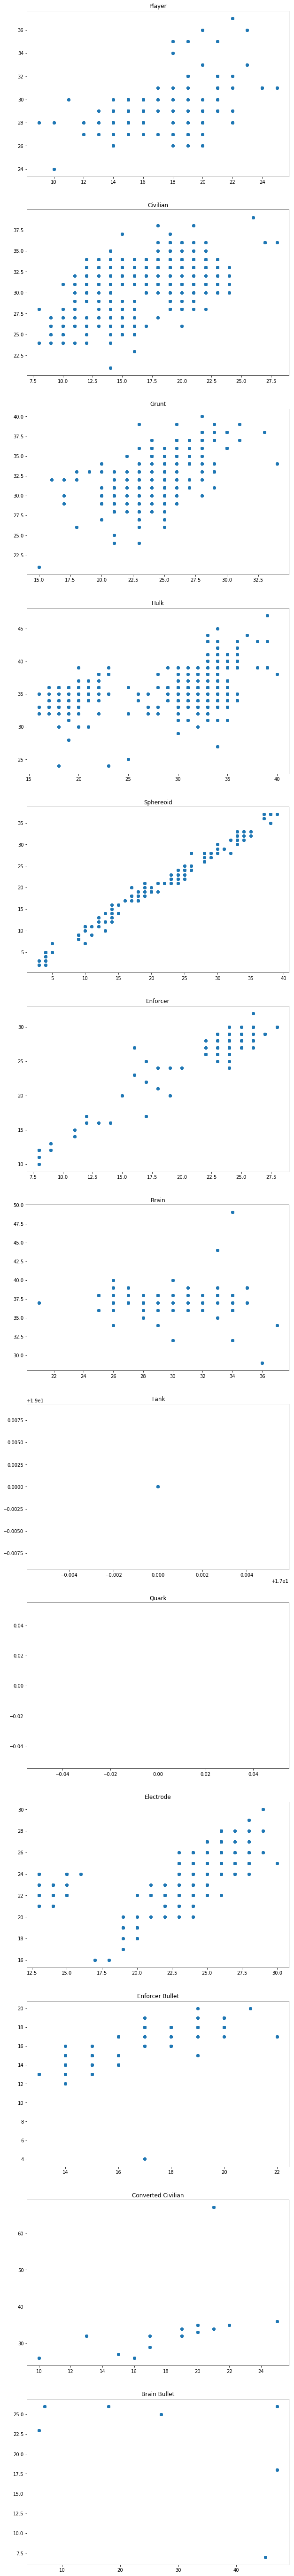

In [103]:
ll = len(classes)
plt.figure(figsize=(10, 100))

for i, c in enumerate(classes.keys()):
    plt.subplot(ll, 1, i+1)
    plt.scatter(classes[c]['widths'], classes[c]['heights'])
    plt.title(c)

In [8]:
# Remove any class with less than 50 for now... we'll collect more data later
for c in classes:
    if c in images and len(images[c]) < 50:
        del images[c]

In [9]:
for i in images.keys():
    l = len(images[i])
    print(f"{i}: {l}")

Player: 162
Civilian: 1021
Grunt: 1052
Hulk: 1248
Sphereoid: 138
Enforcer: 254
Brain: 80
Electrode: 986
Enforcer Bullet: 153


In [10]:
# As we reformat the data, we'll break out 20% for testing.  We do it now, because we want to oversample everything else
# to get a balanced list for training.
train_images = {}
test_images = {}

for c in images.keys():
    d = images[c]
    perc = int(0.8 * len(d))
    train, test = d[:perc], d[perc:]
    train_images[c] = train
    test_images[c] = test

In [11]:
for c in train_images.keys():
    print(c, len(train_images[c]), len(test_images[c]))

Player 129 33
Civilian 816 205
Grunt 841 211
Hulk 998 250
Sphereoid 110 28
Enforcer 203 51
Brain 64 16
Electrode 788 198
Enforcer Bullet 122 31


In [12]:
# Now we can duplicate entries until they all match.  To make it easy, we'll just jump up to 1k
for c in train_images.keys():
    orig_len = len(train_images[c])
    i = 0
    while len(train_images[c]) < 1000:
        train_images[c] = train_images[c] + [train_images[c][i % orig_len]]
        i += 1

In [13]:
for c in train_images.keys():
    print(c, len(train_images[c]), len(test_images[c]))

Player 1000 33
Civilian 1000 205
Grunt 1000 211
Hulk 1000 250
Sphereoid 1000 28
Enforcer 1000 51
Brain 1000 16
Electrode 1000 198
Enforcer Bullet 1000 31


In [14]:
X_train = []
y_train = []
X_test = []
y_test = []
# Now lets turn it into training/testing set.
for idx, c in enumerate(classes):
    if c in train_images:
        X_train = X_train + train_images[c]
        y_train = y_train + [idx] * len(train_images[c])
        X_test = X_test + test_images[c]
        y_test = y_test + [idx] * len(test_images[c])
        
X_train, y_train = shuffle(X_train, y_train)
print(len(X_train), len(y_train), len(X_test), len(y_test))

9000 9000 1023 1023


In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Lets Train!

In [16]:
# From https://github.com/activatedgeek/LeNet-5/blob/b9d7f39a752d23a7de60ea6d679812c401fab57e/lenet.py#L5

class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 13)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [17]:
class Dataset(torchData.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.images = images
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Return image and label
        X = torch.tensor(self.images[index].reshape(1, 32, 32), dtype=torch.float)
        y = torch.tensor(self.labels[index])

        return X, y
    
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

data_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)
data_test_loader = DataLoader(test_dataset, batch_size=256, num_workers=8)

model = LeNet5().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

def train(epoch):
    model.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        loss.backward()
        optimizer.step()


def test():
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        images = images.cuda()
        labels = labels.cuda()
        
        output = model(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(test_dataset)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(test_dataset)))


def train_and_test(epoch):
    print(f"Training Epoch {epoch}")
    train(epoch)
    print("Test")
    test()

In [18]:
for e in range(1, 16):
    train_and_test(e)

Training Epoch 1
Train - Epoch 1, Batch: 0, Loss: 3.099421
Train - Epoch 1, Batch: 10, Loss: 0.629344
Train - Epoch 1, Batch: 20, Loss: 0.326949
Train - Epoch 1, Batch: 30, Loss: 0.189050
Test
Test Avg. Loss: 0.000404, Accuracy: 0.981427
Training Epoch 2
Train - Epoch 2, Batch: 0, Loss: 0.189095
Train - Epoch 2, Batch: 10, Loss: 0.182147
Train - Epoch 2, Batch: 20, Loss: 0.157808
Train - Epoch 2, Batch: 30, Loss: 0.098643
Test
Test Avg. Loss: 0.000374, Accuracy: 0.985337
Training Epoch 3
Train - Epoch 3, Batch: 0, Loss: 0.029584
Train - Epoch 3, Batch: 10, Loss: 0.028749
Train - Epoch 3, Batch: 20, Loss: 0.033097
Train - Epoch 3, Batch: 30, Loss: 0.088025
Test
Test Avg. Loss: 0.000159, Accuracy: 0.997067
Training Epoch 4
Train - Epoch 4, Batch: 0, Loss: 0.038483
Train - Epoch 4, Batch: 10, Loss: 0.014073
Train - Epoch 4, Batch: 20, Loss: 0.007363
Train - Epoch 4, Batch: 30, Loss: 0.009246
Test
Test Avg. Loss: 0.000238, Accuracy: 0.995112
Training Epoch 5
Train - Epoch 5, Batch: 0, Loss

In [19]:
torch.save(model.state_dict(), data_path + "saved_model.pt")